In [1]:
import pandas as pd

# Load the dataset
train = pd.read_csv("../data/train.csv")

In [2]:
# Lade den Kaggle Test Datensatz
# Dieser muss zusammen mit dem Trainingsdatensatz verarbeitet werden, sonst fehlen einige Spalten im Kaggle Testdatensatz!
X_test_kaggle = pd.read_csv("../data/test.csv")
_X_test_kaggle = X_test_kaggle.copy()

X_test_kaggle["Survived"] = 0 # Dummy damit Pandas keine Zicken macht
X_test_kaggle["IsKaggleTestData"] = True

In [3]:
def transform_data(df:pd.DataFrame):
    # Now the names...
    # First, seperate the first and last name
    df[["LastName", "FirstName_tmp"]] = df["Name"].str.split(",", expand=True)
    
    # Now the salutation forms
    df[["SalutForm","FirstName"]] = df["FirstName_tmp"].str.split(".", n=1, expand=True)
    
     # Grouping age
    group_limits = [0, 10, 20, 30, 40, 50 , 60, 70, 100]
    groups = [0, 1, 2, 3, 4, 5, 6, 7]
    df["AgeGroup"] = pd.cut(df['Age'], bins=group_limits, labels=groups)
    
    # Grouping family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    group_limits = [0, 1, 3, 7, 100]
    groups = [0, 1, 2, 3]
    df["FamilySize"] = pd.cut(df['Age'], bins=group_limits, labels=groups)
    
    df = df.drop([
        "PassengerId",
        "FirstName_tmp",
        "FirstName",
        "LastName",
        "Name",
        "Cabin",
        "Ticket"], axis=1)
                              
    return df

In [4]:
train = transform_data(train)
X_test_kaggle = transform_data(X_test_kaggle)
train["IsKaggleTestData"] = False

In [5]:
df = pd.concat([train, X_test_kaggle], axis=0)

In [6]:
num_cols = ["Age", "SibSp", "Parch", "Fare"]
cat_cols = ["Pclass", "Sex", "Embarked", "SalutForm", "FamilySize", "AgeGroup"]
dist_col = ["IsKaggleTestData"]

In [7]:
# Define pipelines and preprocessor
from sklearn import (compose, impute, linear_model, preprocessing)
from sklearn.pipeline import Pipeline

numerical_preprocessor = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="mean")),
    ("scaler", preprocessing.StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", impute.SimpleImputer(strategy="most_frequent")),
    ("onehot", preprocessing.OneHotEncoder(handle_unknown="error", sparse_output=False)),
])

preprocessor = compose.ColumnTransformer(
    transformers=[
        ("numerical", numerical_preprocessor, num_cols),
        ("categorical", categorical_preprocessor, cat_cols),
        ("passthrough", "passthrough", dist_col)
    ]
)

In [8]:
# Split the data

y = df[["Survived","IsKaggleTestData"]]
X = df.drop(["Survived"], axis=1)

In [9]:
# Preprocess the data
preprocessor.set_output(transform="pandas")
X_pipe = preprocessor.fit_transform(X)

In [10]:
X_test_kaggle_pipe = X_pipe.loc[X_pipe["passthrough__IsKaggleTestData"] == True]
X_test_kaggle_pipe = X_test_kaggle_pipe.drop(["passthrough__IsKaggleTestData"], axis = 1)

In [11]:
X_test_kaggle_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__Age                        418 non-null    float64
 1   numerical__SibSp                      418 non-null    float64
 2   numerical__Parch                      418 non-null    float64
 3   numerical__Fare                       418 non-null    float64
 4   categorical__Pclass_1                 418 non-null    float64
 5   categorical__Pclass_2                 418 non-null    float64
 6   categorical__Pclass_3                 418 non-null    float64
 7   categorical__Sex_female               418 non-null    float64
 8   categorical__Sex_male                 418 non-null    float64
 9   categorical__Embarked_C               418 non-null    float64
 10  categorical__Embarked_Q               418 non-null    float64
 11  categorical__Embark

In [12]:
X_train_full_pipe = X_pipe.loc[X_pipe["passthrough__IsKaggleTestData"] == False]
X_train_full_pipe = X_train_full_pipe.drop(["passthrough__IsKaggleTestData"], axis = 1)

In [13]:
X_train_full_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   numerical__Age                        891 non-null    float64
 1   numerical__SibSp                      891 non-null    float64
 2   numerical__Parch                      891 non-null    float64
 3   numerical__Fare                       891 non-null    float64
 4   categorical__Pclass_1                 891 non-null    float64
 5   categorical__Pclass_2                 891 non-null    float64
 6   categorical__Pclass_3                 891 non-null    float64
 7   categorical__Sex_female               891 non-null    float64
 8   categorical__Sex_male                 891 non-null    float64
 9   categorical__Embarked_C               891 non-null    float64
 10  categorical__Embarked_Q               891 non-null    float64
 11  categorical__Embark

In [14]:
y_train_full_pipe = y.loc[y["IsKaggleTestData"] == False]
y_train_full_pipe = y_train_full_pipe.drop(["IsKaggleTestData"], axis = 1)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_full_pipe, y_train_full_pipe, test_size=0.2)

In [16]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

resampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, criterion="log_loss")
model.fit(X_train_resampled, y_train_resampled.values.ravel())

RandomForestClassifier(criterion='log_loss', random_state=42)

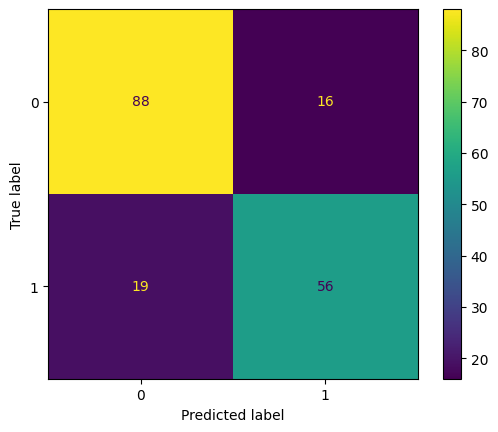

In [18]:
# Konfusionsmatrix und recall sowie precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_predict = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: \t{accuracy_score(y_test, y_test_predict)}")
print(f"Precision: \t{precision_score(y_test, y_test_predict)}")
print(f"Recall: \t{recall_score(y_test, y_test_predict)}")
print(f"F1 Score: \t{f1_score(y_test, y_test_predict)}")

Accuracy: 	0.8044692737430168
Precision: 	0.7777777777777778
Recall: 	0.7466666666666667
F1 Score: 	0.761904761904762


In [20]:
from datetime import datetime

preds_kaggle = model.predict(X_test_kaggle_pipe)
output = pd.DataFrame({"PassengerId": _X_test_kaggle["PassengerId"], "Survived": preds_kaggle})
output_path = f"../submissions/submsission {datetime.today().strftime('%Y-%m-%d %H_%M_%S')}.csv"
# output.to_csv(output_path, index=False)

# Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
gs_model = RandomForestClassifier()

In [23]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy", "log_loss"]
}

In [24]:
grid_search = GridSearchCV(estimator=gs_model, param_grid=param_grid, cv=10, verbose=3, scoring="accuracy")

In [25]:
grid_search.fit(X_train_resampled, y_train_resampled.values.ravel())

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV 1/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.820 total time=   0.1s
[CV 2/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.730 total time=   0.1s
[CV 3/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.764 total time=   0.1s
[CV 4/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.831 total time=   0.1s
[CV 5/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.1s
[CV 6/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.809 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.876 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=None, min_samples_split=2, n_estimators=100;, score=0.820 total time=   0.1s
[

[CV 1/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.831 total time=   0.2s
[CV 2/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.753 total time=   0.3s
[CV 3/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.798 total time=   0.3s
[CV 4/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.820 total time=   0.3s
[CV 5/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.831 total time=   0.3s
[CV 6/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.854 total time=   0.3s
[CV 7/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.876 total time=   0.3s
[CV 8/10] END criterion=gini, max_depth=None, min_samples_split=10, n_estimators=200;, score=0.843 total time=   0.3s
[CV 9/10] END criterion=gini, max_depth=None, min_sample

[CV 3/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.809 total time=   0.4s
[CV 4/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.798 total time=   0.4s
[CV 5/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.798 total time=   0.3s
[CV 6/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.843 total time=   0.4s
[CV 7/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.843 total time=   0.4s
[CV 8/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.742 total time=   0.4s
[CV 9/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.843 total time=   0.4s
[CV 10/10] END criterion=gini, max_depth=5, min_samples_split=5, n_estimators=300;, score=0.809 total time=   0.4s
[CV 1/10] END criterion=gini, max_depth=5, min_samples_split=10, n_estimators=100;, sco

[CV 6/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=100;, score=0.854 total time=   0.1s
[CV 7/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=100;, score=0.854 total time=   0.1s
[CV 8/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=100;, score=0.831 total time=   0.1s
[CV 9/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=100;, score=0.910 total time=   0.1s
[CV 10/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.1s
[CV 1/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.843 total time=   0.2s
[CV 2/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.742 total time=   0.2s
[CV 3/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.820 total time=   0.3s
[CV 4/10] END criterion=gini, max_depth=10, min_samples_split=5, n_estimators=2

[CV 7/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=200;, score=0.865 total time=   0.3s
[CV 8/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=200;, score=0.843 total time=   0.3s
[CV 9/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=200;, score=0.899 total time=   0.3s
[CV 10/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=200;, score=0.888 total time=   0.3s
[CV 1/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.820 total time=   0.5s
[CV 2/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.730 total time=   0.5s
[CV 3/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.764 total time=   0.5s
[CV 4/10] END criterion=entropy, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.809 total time=   0.5s
[CV 5/10] END criterion=entropy, max_de

[CV 6/10] END criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=300;, score=0.843 total time=   0.4s
[CV 7/10] END criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=300;, score=0.876 total time=   0.6s
[CV 8/10] END criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=300;, score=0.831 total time=   0.5s
[CV 9/10] END criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=300;, score=0.921 total time=   0.5s
[CV 10/10] END criterion=entropy, max_depth=None, min_samples_split=10, n_estimators=300;, score=0.865 total time=   0.5s
[CV 1/10] END criterion=entropy, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.865 total time=   0.1s
[CV 2/10] END criterion=entropy, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.753 total time=   0.1s
[CV 3/10] END criterion=entropy, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.1s
[CV 4/10] END criterion=entropy, max_depth=

[CV 6/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.865 total time=   0.1s
[CV 7/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.809 total time=   0.1s
[CV 8/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.764 total time=   0.1s
[CV 9/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.820 total time=   0.1s
[CV 10/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=100;, score=0.809 total time=   0.1s
[CV 1/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.865 total time=   0.2s
[CV 2/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.730 total time=   0.2s
[CV 3/10] END criterion=entropy, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.809 total time=   0.2s
[CV 4/10] END criterion=entropy, max_depth=5, min_sampl

[CV 6/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.854 total time=   0.3s
[CV 7/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.876 total time=   0.3s
[CV 8/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.831 total time=   0.3s
[CV 9/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.899 total time=   0.3s
[CV 10/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=200;, score=0.865 total time=   0.3s
[CV 1/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.831 total time=   0.4s
[CV 2/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.742 total time=   0.5s
[CV 3/10] END criterion=entropy, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.831 total time=   0.5s
[CV 4/10] END criterion=entropy, max_depth=10, min_samp

[CV 5/10] END criterion=log_loss, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.831 total time=   0.5s
[CV 6/10] END criterion=log_loss, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.820 total time=   0.5s
[CV 7/10] END criterion=log_loss, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.865 total time=   0.5s
[CV 8/10] END criterion=log_loss, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.820 total time=   0.5s
[CV 9/10] END criterion=log_loss, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.899 total time=   0.5s
[CV 10/10] END criterion=log_loss, max_depth=None, min_samples_split=2, n_estimators=300;, score=0.888 total time=   0.5s
[CV 1/10] END criterion=log_loss, max_depth=None, min_samples_split=5, n_estimators=100;, score=0.820 total time=   0.1s
[CV 2/10] END criterion=log_loss, max_depth=None, min_samples_split=5, n_estimators=100;, score=0.775 total time=   0.1s
[CV 3/10] END criterion=log_los

[CV 4/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.1s
[CV 5/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.787 total time=   0.1s
[CV 6/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.854 total time=   0.1s
[CV 7/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.798 total time=   0.1s
[CV 8/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.730 total time=   0.1s
[CV 9/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.831 total time=   0.1s
[CV 10/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=100;, score=0.809 total time=   0.1s
[CV 1/10] END criterion=log_loss, max_depth=5, min_samples_split=2, n_estimators=200;, score=0.865 total time=   0.2s
[CV 2/10] END criterion=log_loss, max_depth=5, min_samp

[CV 4/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.798 total time=   0.2s
[CV 5/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.787 total time=   0.2s
[CV 6/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.843 total time=   0.2s
[CV 7/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.820 total time=   0.2s
[CV 8/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.742 total time=   0.2s
[CV 9/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.831 total time=   0.2s
[CV 10/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=200;, score=0.809 total time=   0.2s
[CV 1/10] END criterion=log_loss, max_depth=5, min_samples_split=10, n_estimators=300;, score=0.865 total time=   0.4s
[CV 2/10] END criterion=log_loss, max_depth=5, 

[CV 3/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.809 total time=   0.5s
[CV 4/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.820 total time=   0.4s
[CV 5/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.820 total time=   0.5s
[CV 6/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.854 total time=   0.5s
[CV 7/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.876 total time=   0.5s
[CV 8/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.820 total time=   0.4s
[CV 9/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.910 total time=   0.5s
[CV 10/10] END criterion=log_loss, max_depth=10, min_samples_split=5, n_estimators=300;, score=0.888 total time=   0.5s
[CV 1/10] END criterion=log_loss, max_depth=10,

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=3)

In [26]:
best_model = grid_search.best_estimator_

In [27]:
y_pred = best_model.predict(X_test)

In [28]:
best_params = grid_search.best_params_
print("Beste Parameter:", best_params)
print(f"Bester Score: {grid_search.best_score_}")

Beste Parameter: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Bester Score: 0.8449438202247193


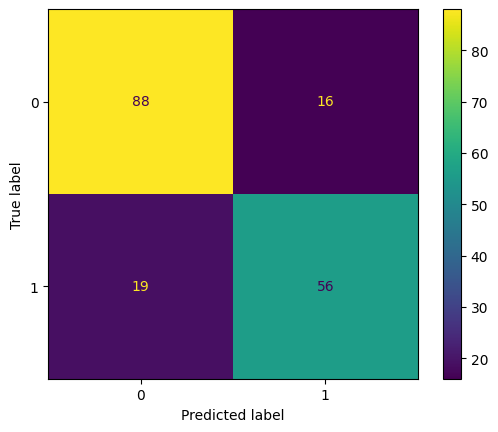

In [29]:
# Konfusionsmatrix und recall sowie precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_predict = model.predict(X_test)
cm = confusion_matrix(y_test, y_test_predict)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: \t{accuracy_score(y_test, y_test_predict)}")
print(f"Precision: \t{precision_score(y_test, y_test_predict)}")
print(f"Recall: \t{recall_score(y_test, y_test_predict)}")
print(f"F1 Score: \t{f1_score(y_test, y_test_predict)}")

Accuracy: 	0.8044692737430168
Precision: 	0.7777777777777778
Recall: 	0.7466666666666667
F1 Score: 	0.761904761904762


In [31]:
from datetime import datetime

preds_kaggle = model.predict(X_test_kaggle_pipe)
output = pd.DataFrame({"PassengerId": _X_test_kaggle["PassengerId"], "Survived": preds_kaggle})
output_path = f"../submissions/submsission {datetime.today().strftime('%Y-%m-%d %H_%M_%S')}.csv"
output.to_csv(output_path, index=False)